# Imports

In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 1.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 29.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scik

2025-09-03 11:19:39.952517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756898380.166977      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756898380.226351      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All done


# Read Data

In [2]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

print("classes names :", (data),)
print("Number of classes :", len(data),)
print("Number of Healty images :", len(Healthy),)
print("Number of Mild images :", len(Mild),)
print("Number of Moderate images :", len(Moderate),)
print("Number of Proliferate images :", len(Proliferate),)
print("Number of severe images :", len(Severe),)

classes names : ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR']
Number of classes : 5
Number of Healty images : 1000
Number of Mild images : 370
Number of Moderate images : 900
Number of Proliferate images : 290
Number of severe images : 190


In [3]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
imgpaths = []
labels =[]

data = os.listdir(Path_data)

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')


Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

Paths     Labels
0  /kaggle/input/diabetic-retinopathy-dataset/Sev...  Severe DR
1  /kaggle/input/diabetic-retinopathy-dataset/Sev...  Severe DR
2  /kaggle/input/diabetic-retinopathy-dataset/Sev...  Severe DR
3  /kaggle/input/diabetic-retinopathy-dataset/Sev...  Severe DR
4  /kaggle/input/diabetic-retinopathy-dataset/Sev...  Severe DR

# Data Preprocessing

In [4]:
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           796
Moderate DR       724
Mild DR           290
Proliferate DR    236
Severe DR         154
Name: count, dtype: int64

# Data Augmentation

In [5]:
batch_size = 20    
img_size = (224, 224) 
channels = 3
img_shape = (img_size[0], img_size[1], channels)


tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()
t_G = ImageDataGenerator()


Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## sample

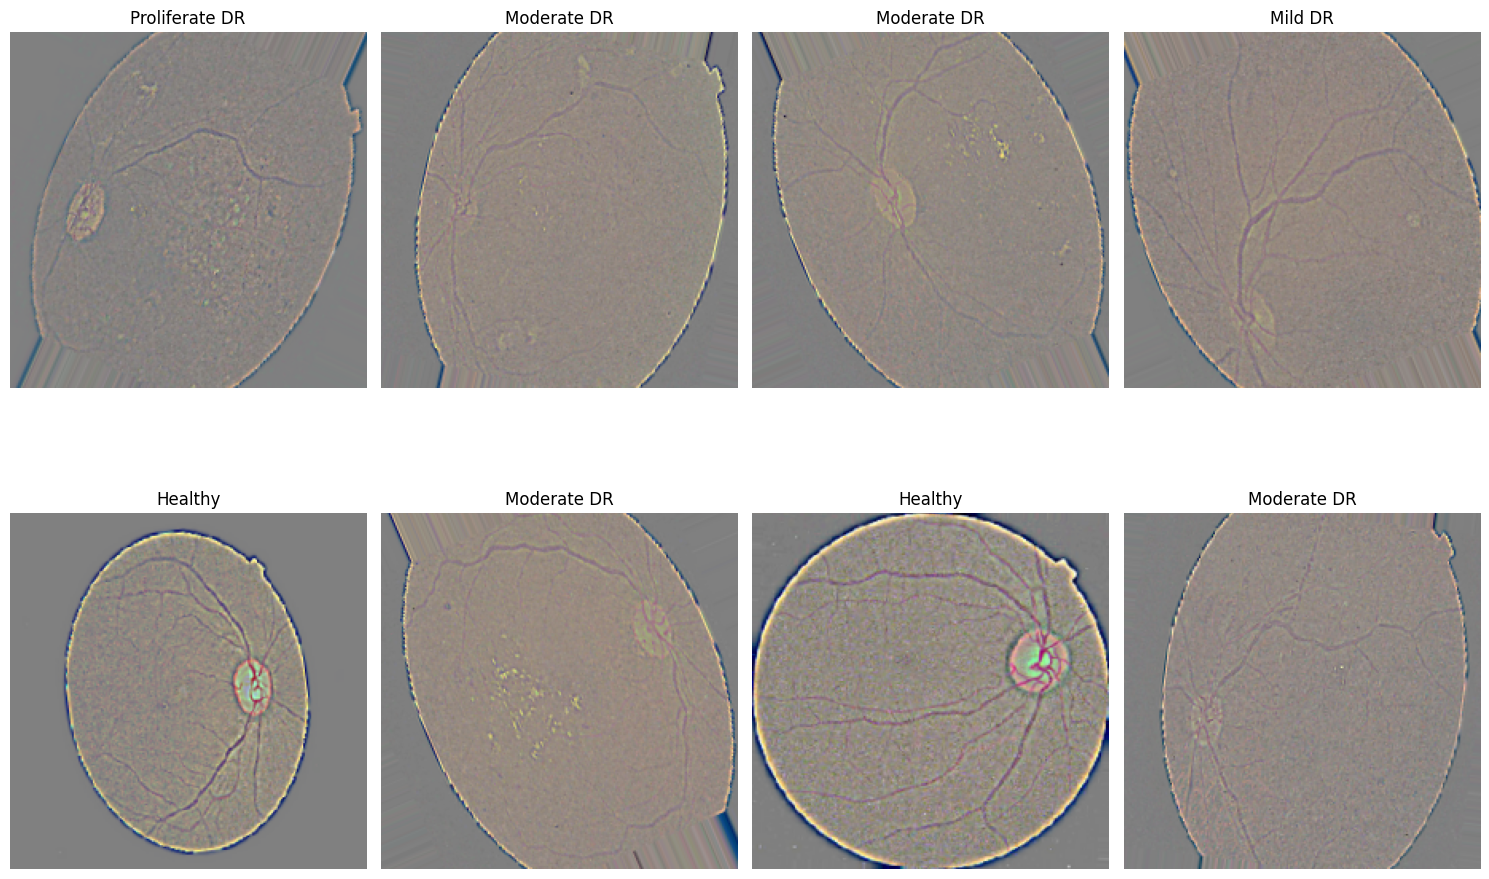

In [6]:
L_index = Train.class_indices
L_index

Keys = list(L_index.keys())
Keys

imgs, labels = next(Train)

plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'black')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

# Modelling

## Create a model using transfer learning with EfficientNetB3

In [7]:
n_classes = len(list(Train.class_indices.keys()))

img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'

base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001)(x)

x = Dense(1024,
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu')(x)
x = Dropout(rate=0.2, seed=123)(x)

x = Dense(512,
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)

x = Dense(256,
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)

output = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

lr = 0.0001

I0000 00:00:1756898402.456395      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [9]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

## Training

In [11]:
epochs = 100
history = model.fit(
    x= Train,
    epochs= epochs,
    verbose= 1,
    validation_data= Valid,
    validation_steps= None,
    shuffle= False
)

Epoch 1/100


I0000 00:00:1756898489.185190      90 service.cc:148] XLA service 0x787bb40065c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756898489.186163      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756898495.923386      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1756898508.583156      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756898508.776261      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756898509.278164      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756898509.4998

110/110 ━━━━━━━━━━━━━━━━━━━━ 201s 612ms/step - acc: 0.3837 - loss: 2.1601 - val_acc: 0.4182 - val_loss: 1.7934
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - acc: 0.5558 - loss: 1.3488 - val_acc: 0.6327 - val_loss: 0.9560
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - acc: 0.5866 - loss: 1.1787 - val_acc: 0.6727 - val_loss: 0.9205
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - acc: 0.6265 - loss: 1.0234 - val_acc: 0.6727 - val_loss: 0.8341
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 271ms/step - acc: 0.6522 - loss: 0.9436 - val_acc: 0.6945 - val_loss: 0.8359
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 273ms/step - acc: 0.6358 - loss: 0.9409 - val_acc: 0.6982 - val_loss: 0.8121
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - acc: 0.6624 - loss: 0.8796 - val_acc: 0.6873 - val_loss: 0.8184
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - acc: 0.6685 - loss: 0.8472 - val_acc: 0.7091 - val_loss: 0.7673
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━

## Evaluation

In [12]:
tr_acc = history.history['acc']
tr_loss = history.history['loss']
v_acc = history.history['val_acc']
v_loss = history.history['val_loss']
index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]
index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## Visualization

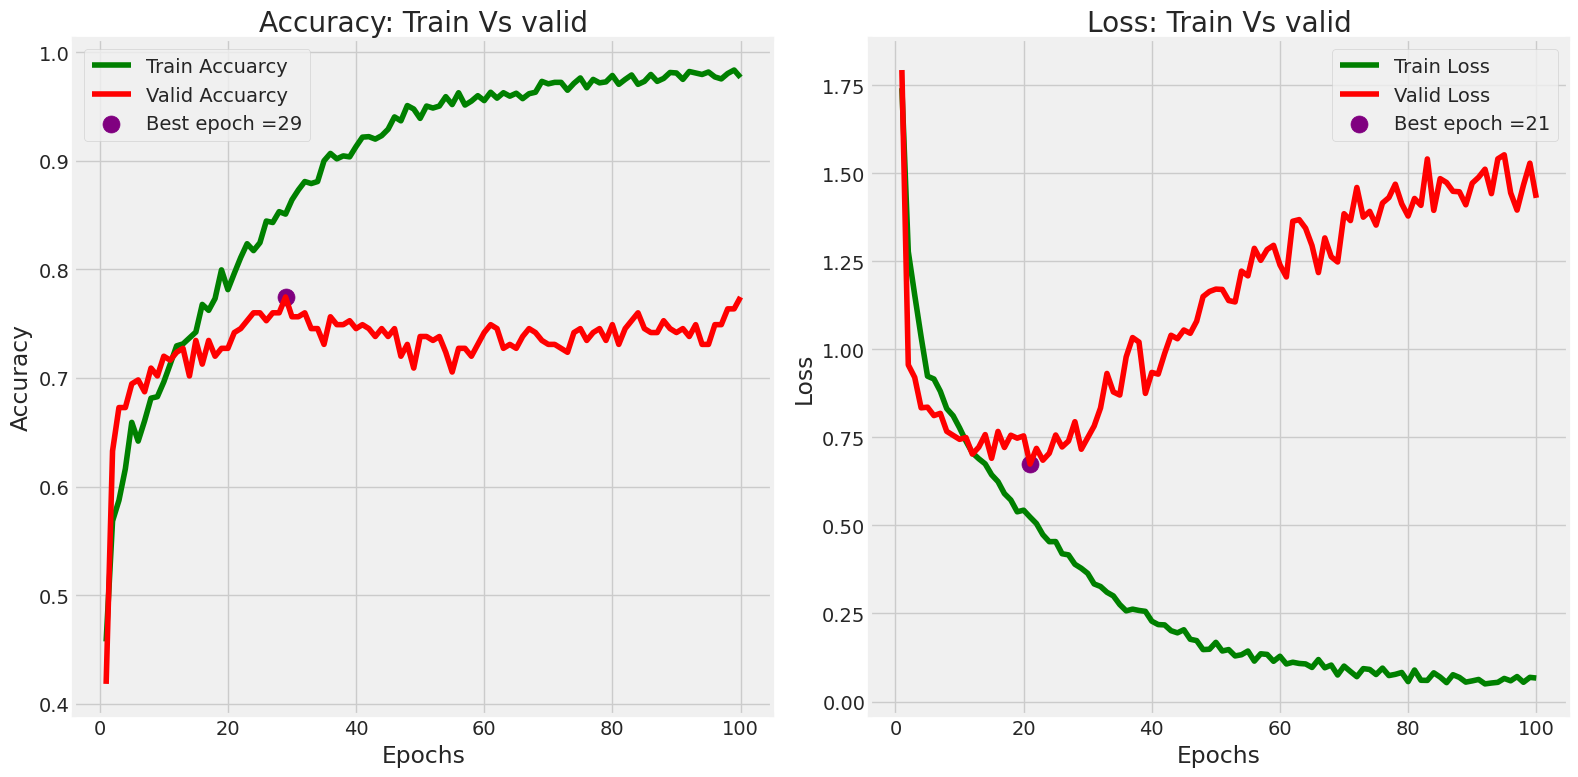

In [13]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - acc: 0.9906 - loss: 0.0256
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - acc: 0.7934 - loss: 1.4148
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - acc: 0.7629 - loss: 1.1898
Train Scores : 
    accuracy: 0.9927272796630859 
      Loss:  0.01927753910422325 
________________________
Valid Scores : 
    accuracy: 0.774545431137085 
      Loss:  1.4303516149520874 
________________________
Test Scores : 
    accuracy: 0.778181791305542 
      Loss:  1.2095017433166504 
________________________


# predictions

In [15]:
predictions = model.predict(Test) 
y_pred = np.argmax(predictions, axis=1)

print(predictions)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 795ms/step
[[1.0000000e+00 7.6224730e-12 2.1562935e-11 5.5339285e-14 4.1906482e-19]
 [1.0000000e+00 3.0757938e-09 7.9717986e-12 2.2390470e-13 4.1754754e-18]
 [8.7238652e-09 8.9336514e-05 9.9990833e-01 2.0926448e-06 1.3198517e-07]
 ...
 [3.0230419e-04 6.7396092e-01 2.8223330e-01 4.2914025e-02 5.8945612e-04]
 [9.9999619e-01 1.4697291e-08 3.6671627e-06 6.7293506e-08 5.4665565e-14]
 [5.3597756e-08 7.6745948e-08 9.9999964e-01 3.4584595e-08 2.5610498e-07]]
[0 0 2 1 3 0 2 1 0 1 2 0 0 4 1 2 1 1 2 0 0 0 0 2 1 1 1 2 1 2 2 0 0 3 0 1 2
 2 2 2 0 3 2 1 2 1 0 2 0 2 1 1 2 4 1 0 2 0 4 2 0 2 1 2 0 2 0 0 0 2 0 2 0 0
 1 4 2 1 0 0 2 1 2 2 0 3 0 4 1 1 2 1 2 1 0 2 2 2 1 4 2 1 4 2 0 0 0 2 1 2 4
 0 3 4 0 2 0 4 2 1 0 2 0 1 1 3 1 0 0 2 0 1 0 2 2 2 2 0 2 1 0 2 0 0 0 0 0 0
 0 4 0 0 0 0 1 0 0 2 2 2 2 1 2 0 1 2 0 0 1 0 2 0 4 2 1 4 0 0 0 2 2 1 2 3 0
 2 0 2 2 1 2 0 2 0 0 3 2 2 1 1 2 1 0 2 0 4 1 2 2 0 2 0 2 2 0 0 1 0 2 0 2 2
 2 2 2 3 4 2 4 0 2 0 0 0 0 0 0 0 1 2 0 0 2 2 0 3 0 0 2 0 0 1 2 1

In [16]:
Test_cl_ind = Test.class_indices
classes = list(Test_cl_ind.keys())

cm = confusion_matrix(Test.classes, y_pred)
cm

array([[96,  2,  1,  0,  0],
       [ 3, 33,  9,  1,  0],
       [ 2, 11, 69,  0,  8],
       [ 0,  3,  9,  8,  2],
       [ 0,  2,  6,  2,  8]])

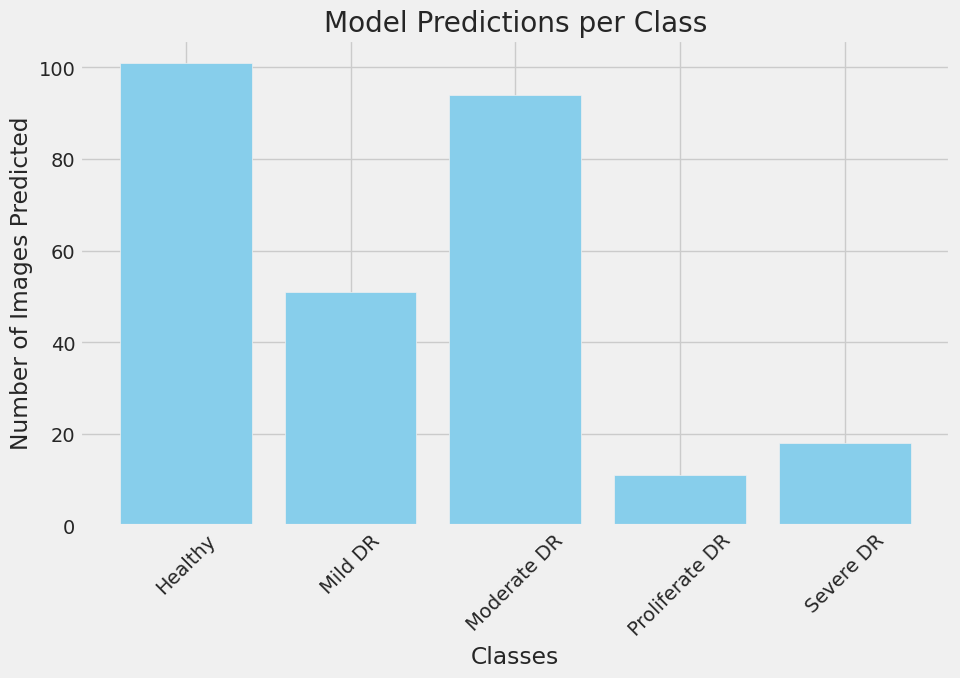

In [17]:
pred_labels = [classes[i] for i in y_pred]
pred_counts = {cls: pred_labels.count(cls) for cls in classes}

plt.figure(figsize=(10,6))
plt.bar(pred_counts.keys(), pred_counts.values(), color='skyblue')
plt.title("Model Predictions per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images Predicted")
plt.xticks(rotation=45)
plt.show()

Found 275 validated image filenames belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


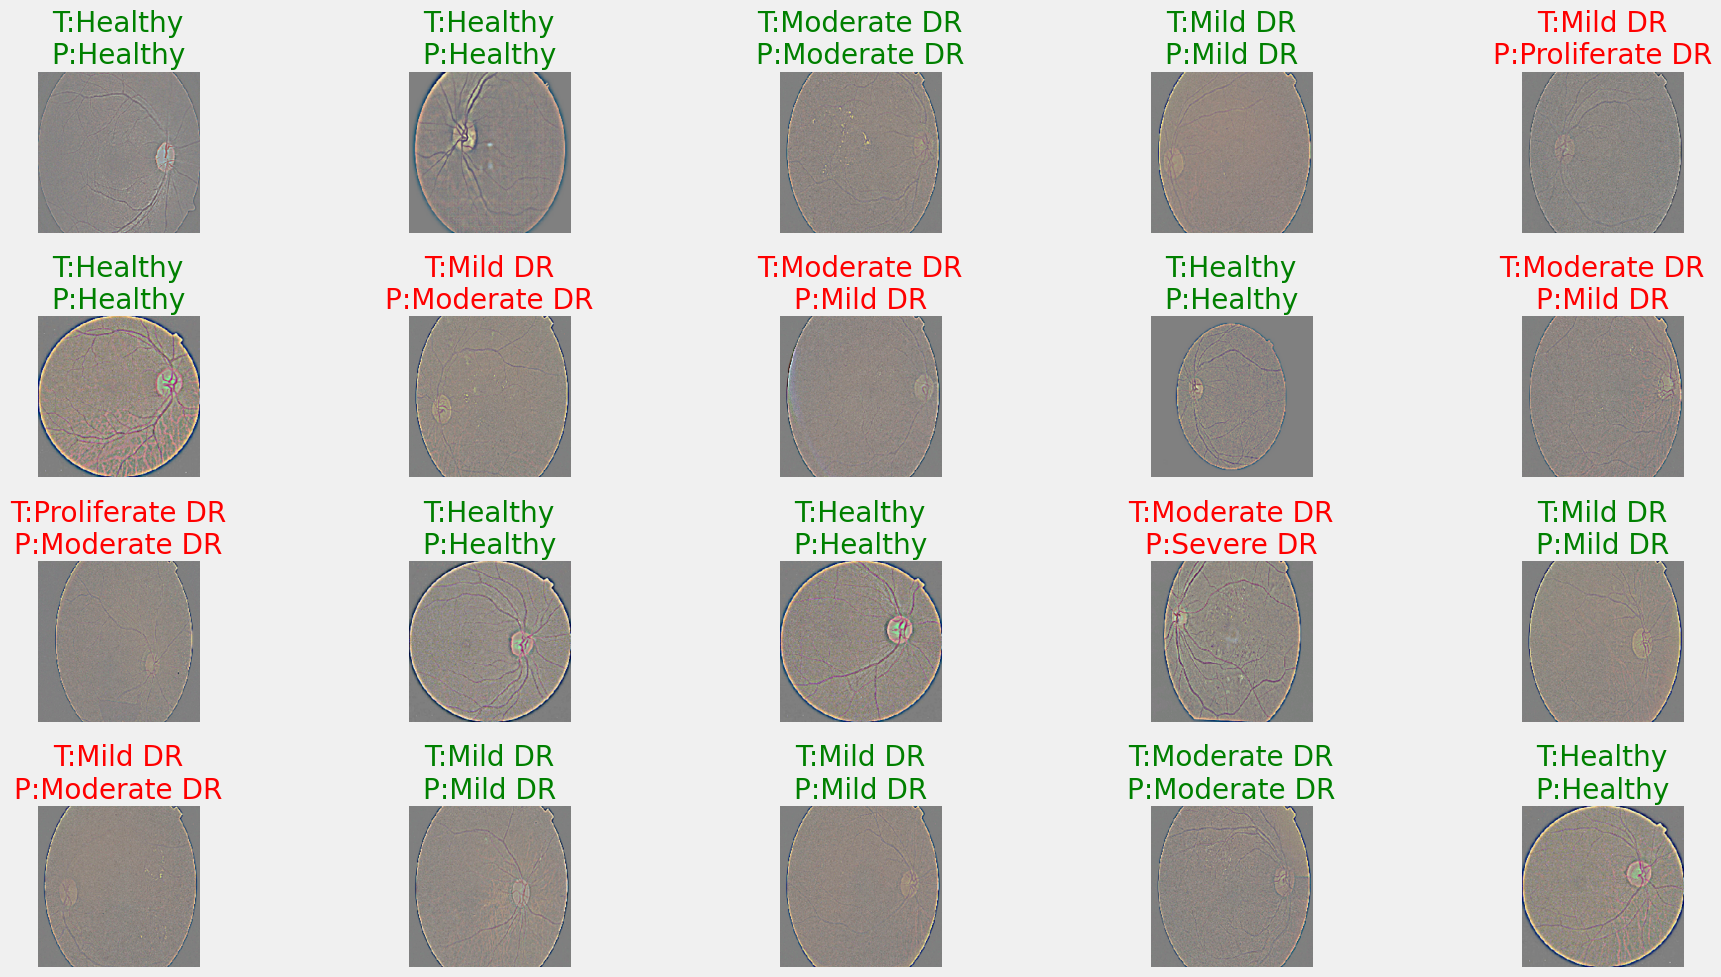

In [18]:
import matplotlib.pyplot as plt
import numpy as np

imgs, labels_true = next(t_G.flow_from_dataframe(test, x_col='Paths', y_col='Labels', target_size=img_size, 
                                                 class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=20))

predictions_batch = model.predict(imgs)
y_pred_batch = np.argmax(predictions_batch, axis=1)
y_true_batch = np.argmax(labels_true, axis=1)

plt.figure(figsize=(20,10))

for i in range(len(imgs)):
    plt.subplot(4, 5, i+1)
    plt.imshow(imgs[i]/255)
    plt.axis('off')
    true_label = classes[y_true_batch[i]]
    pred_label = classes[y_pred_batch[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"T:{true_label}\nP:{pred_label}", color=color)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


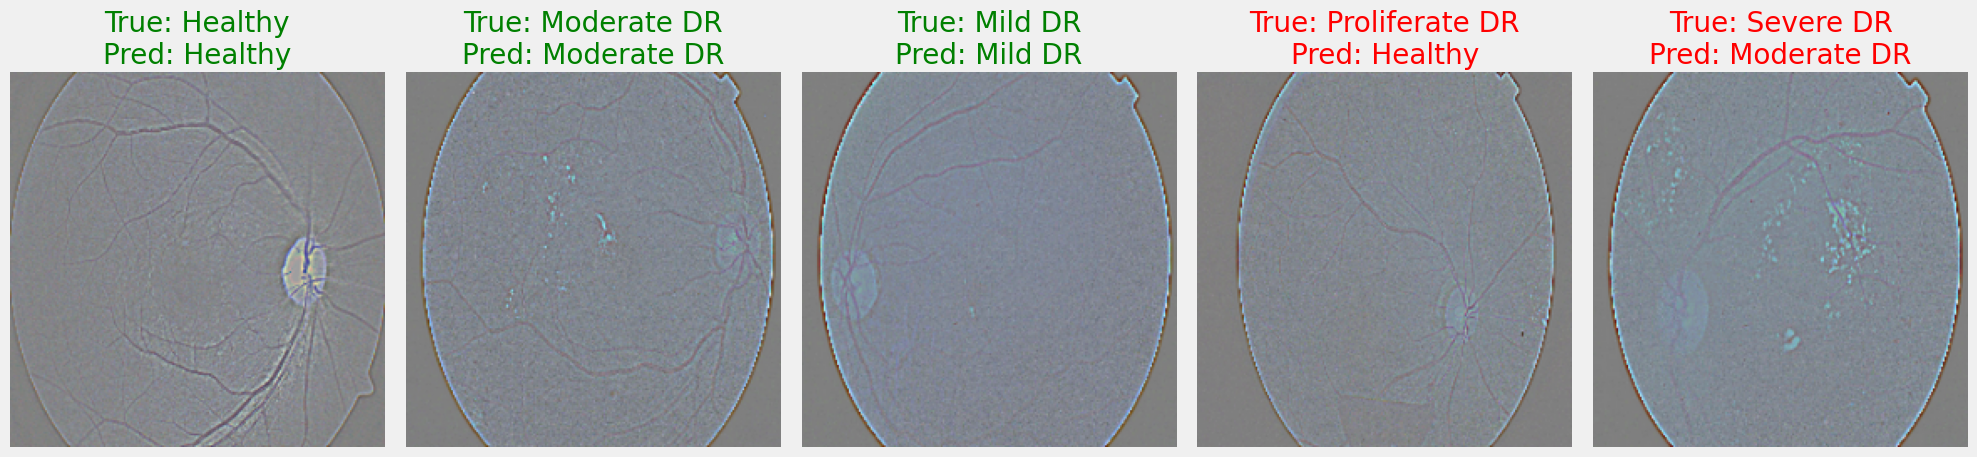

In [19]:
class_to_index = Test.class_indices
index_to_class = {v:k for k,v in class_to_index.items()}

sample_per_class = {}

for idx, row in test.iterrows():
    label_idx = class_to_index[row['Labels']]
    if label_idx not in sample_per_class:
        img = cv2.imread(row['Paths'])
        img = cv2.resize(img, img_size)
        sample_per_class[label_idx] = (img, label_idx)
    if len(sample_per_class) == len(class_to_index):
        break

imgs = np.array([v[0] for v in sample_per_class.values()])
true_labels = np.array([v[1] for v in sample_per_class.values()])

preds = model.predict(imgs)
y_pred_batch = np.argmax(preds, axis=1)

plt.figure(figsize=(20,6))
for i, idx in enumerate(true_labels):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i]/255)
    color = 'green' if y_pred_batch[i] == idx else 'red'
    plt.title(f"True: {index_to_class[idx]}\nPred: {index_to_class[y_pred_batch[i]]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion Matrix

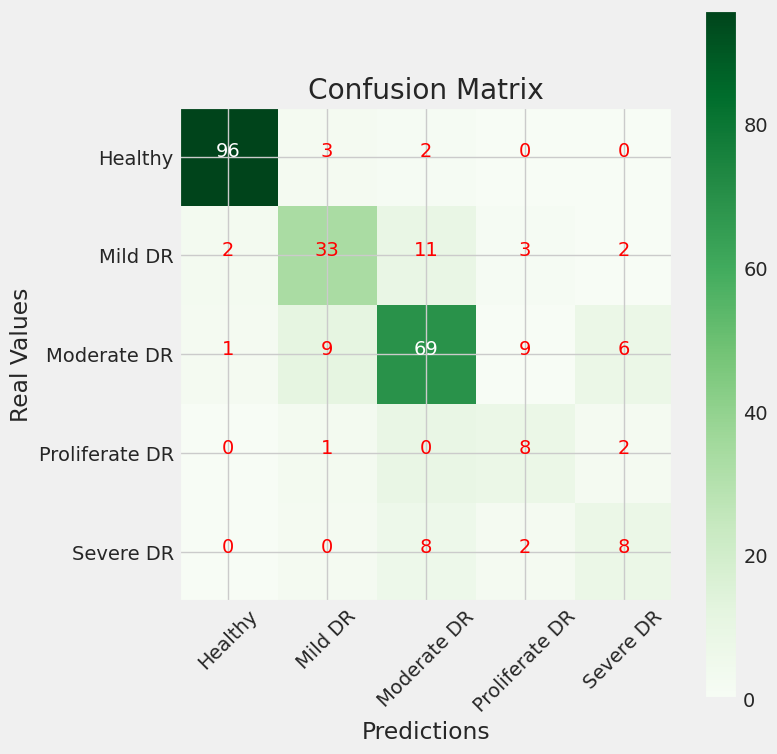

In [20]:
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

# classification report

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis=1)
y_true = Test.classes

overall_acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_acc:.4f}\n")

Test_cl_ind = Test.class_indices
classes = list(Test_cl_ind.keys())
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Overall Accuracy: 0.7782

Classification Report:
                 precision    recall  f1-score   support

       Healthy       0.95      0.97      0.96        99
       Mild DR       0.65      0.72      0.68        46
   Moderate DR       0.73      0.77      0.75        90
Proliferate DR       0.73      0.36      0.48        22
     Severe DR       0.44      0.44      0.44        18

      accuracy                           0.78       275
     macro avg       0.70      0.65      0.66       275
  weighted avg       0.78      0.78      0.77       275



# Summary


=== MODEL EVALUATION SUMMARY ===

Train Accuracy: 0.9927 | Train Loss: 0.0207
Valid Accuracy: 0.7745 | Valid Loss: 1.4304
Test  Accuracy: 0.7782 | Test  Loss: 1.2095

Best Validation Accuracy at Epoch 29: 0.7745
Lowest Validation Loss    at Epoch 21: 0.6744

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Confusion Matrix:

[[96  2  1  0  0]
 [ 3 33  9  1  0]
 [ 2 11 69  0  8]
 [ 0  3  9  8  2]
 [ 0  2  6  2  8]]


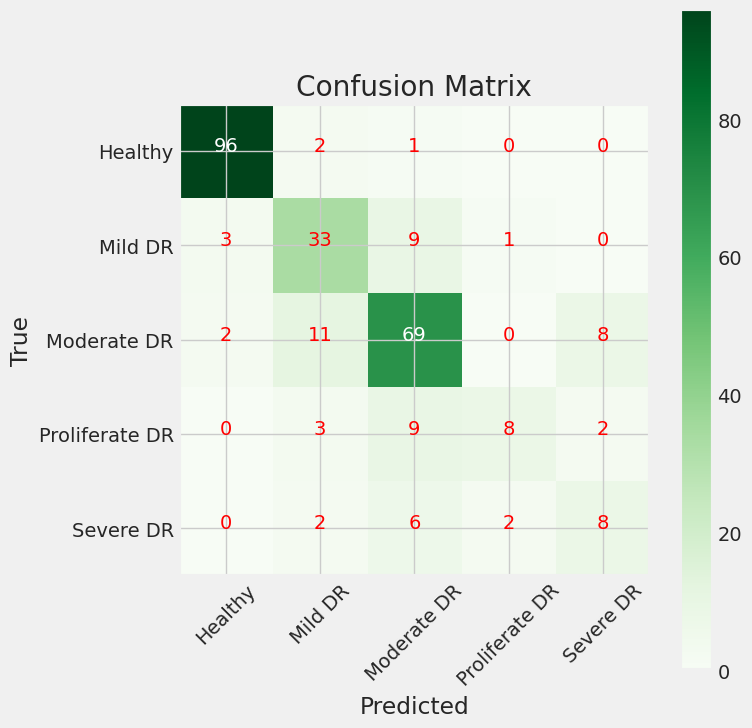


Classification Report:

                precision    recall  f1-score   support

       Healthy       0.95      0.97      0.96        99
       Mild DR       0.65      0.72      0.68        46
   Moderate DR       0.73      0.77      0.75        90
Proliferate DR       0.73      0.36      0.48        22
     Severe DR       0.44      0.44      0.44        18

      accuracy                           0.78       275
     macro avg       0.70      0.65      0.66       275
  weighted avg       0.78      0.78      0.77       275


Predicted samples per class:
 {'Healthy': 101, 'Mild DR': 51, 'Moderate DR': 94, 'Proliferate DR': 11, 'Severe DR': 18}


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

train_score = model.evaluate(Train, verbose=0)
valid_score = model.evaluate(Valid, verbose=0)
test_score  = model.evaluate(Test, verbose=0)

print("\n=== MODEL EVALUATION SUMMARY ===\n")
print(f"Train Accuracy: {train_score[1]:.4f} | Train Loss: {train_score[0]:.4f}")
print(f"Valid Accuracy: {valid_score[1]:.4f} | Valid Loss: {valid_score[0]:.4f}")
print(f"Test  Accuracy: {test_score[1]:.4f} | Test  Loss: {test_score[0]:.4f}\n")

index_acc  = np.argmax(history.history['val_acc'])
index_loss = np.argmin(history.history['val_loss'])
print(f"Best Validation Accuracy at Epoch {index_acc+1}: {history.history['val_acc'][index_acc]:.4f}")
print(f"Lowest Validation Loss    at Epoch {index_loss+1}: {history.history['val_loss'][index_loss]:.4f}\n")

preds = model.predict(Test)
y_pred = np.argmax(preds, axis=1)
classes = list(Test.class_indices.keys())

cm = confusion_matrix(Test.classes, y_pred)
print("Confusion Matrix:\n")
print(cm)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', 
             color='white' if cm[i,j] > thresh else 'red')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

report = classification_report(Test.classes, y_pred, target_names=classes)
print("\nClassification Report:\n")
print(report)

pred_labels = [classes[i] for i in y_pred]
pred_counts = {cls: pred_labels.count(cls) for cls in classes}
print("\nPredicted samples per class:\n", pred_counts)

# Saving model

In [25]:
model.save('best-effB3-DR-model.h5')